In [1]:
import tensorflow as tf
from keras.datasets import mnist
(img_train, label_train), (img_test, label_test) = mnist.load_data()

import numpy as np
import matplotlib.pyplot as plt
import time

Using TensorFlow backend.


In [2]:
# split test data
test_img = {}
for idx in range(10):
    test_img[idx] = []

for idx in range(len(img_test)):
    test_img[label_test[idx]].append(img_test[idx])
for num in range(10):
    test_img[num] = np.array(test_img[num])

for num in range(10):
    print("shape of {} : {}".format(num, test_img[num].shape))

shape of 0 : (980, 28, 28)
shape of 1 : (1135, 28, 28)
shape of 2 : (1032, 28, 28)
shape of 3 : (1010, 28, 28)
shape of 4 : (982, 28, 28)
shape of 5 : (892, 28, 28)
shape of 6 : (958, 28, 28)
shape of 7 : (1028, 28, 28)
shape of 8 : (974, 28, 28)
shape of 9 : (1009, 28, 28)


In [3]:
# split training data
org_image = {}
for idx in range(10):
    org_image[idx] = []

for idx in range(len(img_train)):
    org_image[label_train[idx]].append(img_train[idx])
for num in range(10):
    org_image[num] = np.array(org_image[num])

for num in range(10):
    print("shape of {} : {}".format(num, org_image[num].shape))

shape of 0 : (5923, 28, 28)
shape of 1 : (6742, 28, 28)
shape of 2 : (5958, 28, 28)
shape of 3 : (6131, 28, 28)
shape of 4 : (5842, 28, 28)
shape of 5 : (5421, 28, 28)
shape of 6 : (5918, 28, 28)
shape of 7 : (6265, 28, 28)
shape of 8 : (5851, 28, 28)
shape of 9 : (5949, 28, 28)


In [4]:
image = {}
#helper = [10, 10, 100, 100, 100, 300, 300, 1000, 1000, 1000]
helper = [1000, 1000, 300, 100, 100, 10, 10, 10, 10, 300]

for num in range(10):
    idxs = np.random.permutation(range(len(org_image[num])))
    image[num] = org_image[num][idxs[0:helper[num]]]
    print("The number of {} : {}".format(num, image[num].shape))

The number of 0 : (1000, 28, 28)
The number of 1 : (1000, 28, 28)
The number of 2 : (300, 28, 28)
The number of 3 : (100, 28, 28)
The number of 4 : (100, 28, 28)
The number of 5 : (10, 28, 28)
The number of 6 : (10, 28, 28)
The number of 7 : (10, 28, 28)
The number of 8 : (10, 28, 28)
The number of 9 : (300, 28, 28)


In [5]:
from keras.utils import np_utils

img_row, img_col = img_train.shape[1], img_train.shape[2]
img_depth = 1

img_train = img_train.reshape(img_train.shape[0], img_row, img_col, img_depth)
img_test = img_test.reshape(img_test.shape[0], img_row, img_col, img_depth)
img_train = img_train.astype('float32')
img_test = img_test.astype('float32')
img_train /= 255
img_test /= 255

label_train = np_utils.to_categorical(label_train, 10)
label_test = np_utils.to_categorical(label_test, 10)

In [6]:
W = np.load('./Weights/weights_transfer_Conv1_Fc1_minor2_epcoh1.npy')

In [7]:
X = tf.placeholder(tf.float32, [None, img_row, img_col, img_depth])
Y = tf.placeholder(tf.float32, [None, 10])
training = tf.placeholder(tf.bool)

with tf.variable_scope('conv_layer'):
    conv1 = tf.layers.conv2d(inputs=X, filters=32, kernel_size=[3, 3], 
                             kernel_initializer=tf.constant_initializer(W[0]), bias_initializer=tf.constant_initializer(W[1]),
                            padding='SAME', activation=tf.nn.relu, name='conv1')
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], 
                                    padding='SAME', strides=2, name='pool1')
    conv2 = tf.layers.conv2d(inputs=pool1, filters=32, kernel_size=[3, 3], 
                             kernel_initializer=tf.constant_initializer(W[2]), bias_initializer=tf.constant_initializer(W[3]),
                            padding='SAME', activation=tf.nn.relu, name='conv2')
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], 
                                    padding='SAME', strides=2, name='pool2')
    conv3 = tf.layers.conv2d(inputs=pool2, filters=32, kernel_size=[3, 3],
                             kernel_initializer=tf.constant_initializer(W[4]), bias_initializer=tf.constant_initializer(W[5]),
                            padding='SAME', activation=tf.nn.relu, name='conv3')
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], 
                                padding='SAME', strides=2, name='pool3')
with tf.variable_scope('fc_layer'):
    flat = tf.reshape(pool3, [-1, 4*4*32], name='flat')
    dense1 = tf.layers.dense(inputs=flat, units=1024, activation=tf.nn.relu, 
                             kernel_initializer=tf.constant_initializer(W[6]), bias_initializer=tf.constant_initializer(W[7]),
                             name='dense1')
    drop1 = tf.layers.dropout(inputs=dense1, rate=0.5, training=training)
    dense2 = tf.layers.dense(inputs=drop1, units=512, activation=tf.nn.relu, 
                             kernel_initializer=tf.constant_initializer(W[8]), bias_initializer=tf.constant_initializer(W[9]),
                             name='dense2')
    drop2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=training)
    logits = tf.layers.dense(inputs=drop2, units=10, 
                            kernel_initializer=tf.constant_initializer(W[10]), bias_initializer=tf.constant_initializer(W[11]),)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
def get_accuracy(sess, logits, img, label):
    if len(img) > 5000:
        num = int(len(img)/2)
        logit1 = sess.run(logits, feed_dict={X: img[0:num], Y: label[0:num], training: False})
        logit2 = sess.run(logits, feed_dict={X: img[num:num*2], Y: label[num:num*2], training: False})
        logit = np.concatenate((logit1, logit2), axis=0)
    else:
        num = len(img)
        logit = sess.run(logits, feed_dict={X: img, Y: label, training: False})
    
    equal = np.equal(np.argmax(logit, 1), np.argmax(label, 1))
    predict = equal.astype(np.float32)
    accuracy = np.mean(predict)
    
    return accuracy, predict, logit

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
test_accuracy, _, _ = get_accuracy(sess, logits, img_test, label_test)
print ('Test Accuracy : {:.5f}'.format(test_accuracy))

Test Accuracy : 0.95130


In [10]:
for num in range(10):
    specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
    specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), 
                                                                    specific_label)
    print("The specific accurcy of {} : {:.5f}".format(num, specific_test_accuracy))
acc, _, _ = get_accuracy(sess, logits, img_test, label_test)
print("Total accuracy : {:.5f}".format(acc))

The specific accurcy of 0 : 0.98061
The specific accurcy of 1 : 0.99207
The specific accurcy of 2 : 0.98450
The specific accurcy of 3 : 0.97327
The specific accurcy of 4 : 0.96334
The specific accurcy of 5 : 0.92713
The specific accurcy of 6 : 0.96451
The specific accurcy of 7 : 0.87646
The specific accurcy of 8 : 0.93532
The specific accurcy of 9 : 0.93162
Total accuracy : 0.95130


0.785874
191 / 892
wrong prediction
[3 3 3 0 3 9 3 3 3 9 4 3 3 3]
[0 8 7 9 3 0 3 3 9 0 3 4 8 0]
[8 3 9 8 9 3 8 0 9 8 3 3 4 0]
[3 3 8 3 9 1 3 3 3 3 9 8 0 3]
[8 3 3 3 9 8 3 6 3 3 3 3 9 3]
[3 3 8 0 8 3 8 8 8 3 0 3 9 3]
[3 3 9 3 3 3 0 9 9 3 8 3 0 3]
[9 3 9 3 3 3 3 3 3 9 8 3 3 3]
[3 3 3 3 3 3 3 3 8 8 3 3 9 3]
[8 9 3 8 3 3 8 8 3 3 2 3 0 3]
[3 3 3 3 3 3 3 3 3 3 3 3 2 3]
[3 3 3 9 9 8 3 2 2 3 3 8 3 3]
[3 3 3 3 3 4 3 3 3 3 3 3 3 3]
[3 0 0 0 1 3 0 3 0]
The number of prediction as 0 : 18
The number of prediction as 1 : 2
The number of prediction as 2 : 4
The number of prediction as 3 : 114
The number of prediction as 4 : 4
The number of prediction as 6 : 1
The number of prediction as 7 : 1
The number of prediction as 8 : 25
The number of prediction as 9 : 22


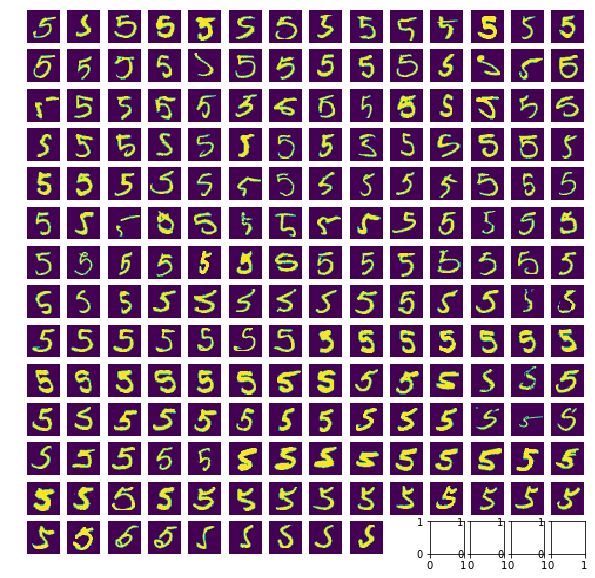

0.719207
269 / 958
wrong prediction
[2 0 0 4 5 0 4 8 0 0 0 8 5 2 4 4 0]
[5 2 8 0 0 2 2 0 5 8 1 8 8 0 4 2 2]
[4 8 0 0 0 0 2 4 0 5 2 5 0 8 5 2 0]
[0 8 0 0 8 0 0 1 0 2 2 0 2 2 2 4 7]
[2 4 0 0 0 4 1 0 2 0 4 0 0 0 0 0 0]
[2 2 4 8 2 4 5 4 0 2 8 5 7 0 2 5 0]
[0 2 2 2 5 5 0 0 5 8 0 5 8 5 0 2 4]
[0 2 2 0 2 4 0 0 0 7 8 0 0 0 0 0 2]
[0 0 0 5 5 2 4 4 0 0 2 8 2 2 0 8 2]
[2 0 2 0 5 5 2 2 5 0 0 0 0 0 0 0 4]
[4 4 4 0 4 4 2 4 4 4 0 2 4 2 2 0 4]
[5 2 4 2 4 4 2 4 2 8 2 2 5 0 5 2 0]
[4 4 4 0 0 0 0 0 2 5 0 0 0 2 2 2 2]
[2 5 2 2 2 2 0 0 2 2 2 0 2 2 2 2 2]
[2 2 2 2 2 2 4 0 2 2 2 2 2 2 2 0 0]
[0 2 4 0 0 2 2 0 0 0 0 0 0 0]
[]
The number of prediction as 0 : 98
The number of prediction as 1 : 3
The number of prediction as 2 : 84
The number of prediction as 4 : 38
The number of prediction as 5 : 25
The number of prediction as 7 : 3
The number of prediction as 8 : 18


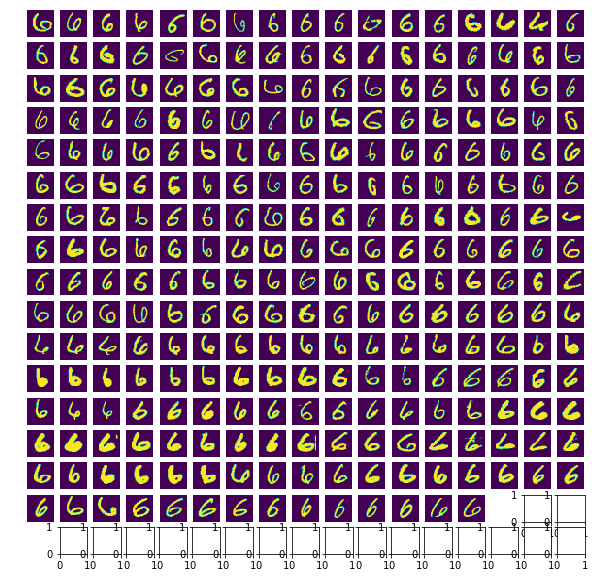

In [12]:
num = 6
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])
        
logit_class = {}
for num in range(10):
    logit_class[num]= 0
    
for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

plt.show()

0.610895
400 / 1028
wrong prediction
[3 9 2 3 3 4 9 9 8 2 4 2 9 3 2 3 3 3 2 1]
[3 2 3 1 2 3 8 5 8 9 4 0 9 2 2 9 9 8 2 2]
[3 3 2 2 6 9 2 9 2 3 2 9 9 2 9 2 8 3 1 2]
[2 2 9 8 2 3 9 2 9 5 9 3 2 9 2 2 9 0 1 2]
[2 4 2 3 1 9 0 2 3 3 5 2 9 8 9 2 9 3 2 3]
[2 2 8 1 4 9 3 3 3 2 4 2 3 1 2 2 2 2 9 2]
[3 4 3 6 2 3 9 2 4 2 3 9 9 1 3 9 9 1 2 3]
[2 2 3 3 3 8 9 2 2 4 2 4 3 9 0 2 3 1 9 1]
[2 2 1 3 2 3 2 9 3 9 3 2 2 8 4 3 2 1 3 1]
[8 8 3 9 2 2 0 9 3 8 2 2 3 3 1 9 8 3 2 3]
[8 3 3 8 9 2 9 8 2 3 3 9 9 2 5 3 3 1 2 3]
[3 1 3 2 3 3 0 8 0 9 2 2 9 9 9 9 9 9 9 9]
[9 3 9 9 9 9 9 9 9 9 9 9 9 5 1 3 3 3 9 8]
[9 9 8 9 9 9 8 9 1 1 1 3 8 3 9 9 9 5 9 9]
[9 9 9 9 5 9 8 9 9 1 2 0 5 8 5 8 2 8 3 3]
[9 0 9 9 9 9 2 5 8 8 4 9 3 9 0 9 8 9 9 8]
[9 9 9 8 8 2 2 2 2 2 3 9 2 8 8 8 0 0 3 3]
[1 3 3 1 3 1 3 3 3 9 3 3 5 5 8 5 5 9 5 2]
[2 2 2 2 2 2 2 9 4 9 9 5 8 8 5 5 5 8 8 9]
[3 2 1 9 1 5 5 0 8 8 5 0 8 9 9 5 8 3 3 9]
The number of prediction as 0 : 14
The number of prediction as 1 : 27
The number of prediction as 2 : 89
The number of pred

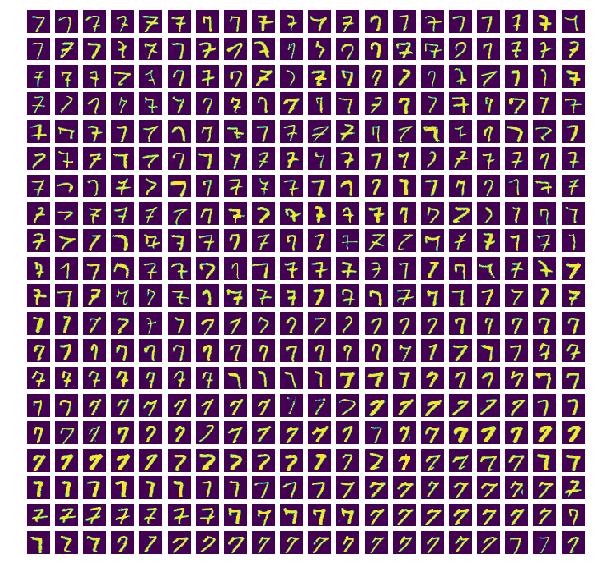

In [13]:
num = 7
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])
        
logit_class = {}
for num in range(10):
    logit_class[num]= 0
    
for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

plt.show()

0.557495
431 / 974
wrong prediction
[6 5 4 2 2 0 2 0 2 4 2 9 2 3 9 9 2 7 5 4 6]
[6 9 7 5 2 2 5 9 2 3 9 2 0 9 5 5 7 9 2 5 5]
[5 9 5 9 0 9 4 2 9 2 2 9 9 5 9 3 3 2 0 9 9]
[7 2 9 2 7 4 9 3 3 3 3 0 9 9 0 9 7 3 0 5 2]
[2 3 9 0 7 9 3 9 3 2 0 2 3 7 9 4 6 0 4 9 0]
[2 2 5 9 9 4 2 0 2 2 5 7 2 9 3 6 9 3 0 7 0]
[9 4 2 2 4 9 2 6 0 7 6 9 2 9 0 2 3 2 0 0 6]
[9 2 3 5 0 9 9 9 3 5 5 0 5 5 5 5 2 5 2 9 2]
[0 0 0 5 6 2 5 2 9 3 2 7 9 0 5 3 2 0 9 2 3]
[2 4 9 0 2 2 2 2 9 9 9 3 5 7 3 0 5 6 9 0 5]
[2 9 9 2 3 5 7 2 0 5 5 9 5 2 9 4 6 2 9 4 5]
[7 4 2 5 3 2 4 4 4 4 6 6 4 9 0 9 9 9 5 0 5]
[3 5 0 0 0 0 0 6 6 4 5 6 3 6 6 2 2 2 2 2 6]
[2 5 9 9 9 9 0 0 0 2 3 2 2 2 2 2 2 2 2 6 9]
[3 9 2 5 5 6 6 6 6 6 5 6 2 2 3 9 2 9 6 2 0]
[9 9 9 2 0 6 3 5 2 0 5 0 4 5 4 0 0 5 0 0 3]
[0 2 2 0 2 2 2 2 2 6 2 5 0 9 9 2 6 9 2 5 2]
[5 6 6 6 6 5 2 4 4 9 4 2 6 5 2 5 5 5 2 6 0]
[0 9 5 9 5 9 9 9 9 6 0 6 5 9 9 3 9 9 9 9 6]
[6 6 5 5 3 5 2 2 6 2 4 6 6 2 2 0 3 2 5 3 3]
[6 6 6 6 5 6 2 6 6 0 5]
The number of prediction as 0 : 70
The number of prediction 

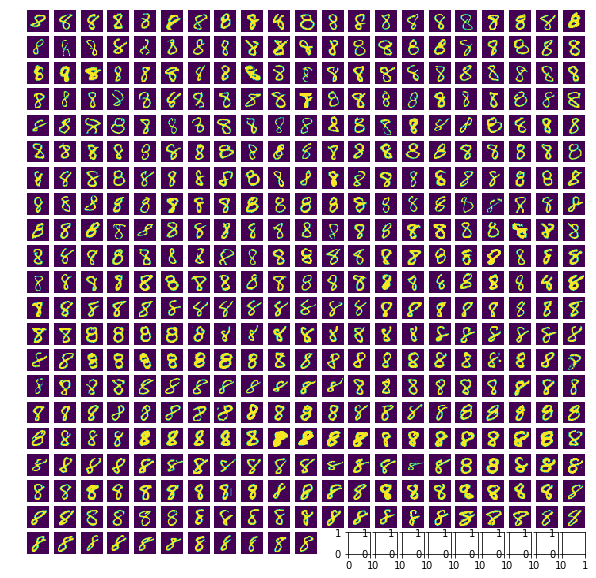

In [14]:
num = 8
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])

for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

plt.show()

0.914767
86 / 1009
wrong prediction
[8 4 7 8 5 4 7 4 5 7]
[4 7 4 4 8 1 4 2 1 8]
[4 2 5 0 5 7 3 1 8 8]
[8 3 4 8 5 8 5 5 5 7]
[7 4 8 1 5 4 5 8 4 8]
[7 5 5 5 3 5 5 8 8 5]
[7 0 0 7 8 8 5 6 5 4]
[8 5 5 5 5 7 8 7 7 8]
[7 3 8 5 5 5]
[]
The number of prediction as 0 : 73
The number of prediction as 1 : 31
The number of prediction as 2 : 190
The number of prediction as 3 : 123
The number of prediction as 4 : 52
The number of prediction as 5 : 111
The number of prediction as 6 : 54
The number of prediction as 7 : 29
The number of prediction as 8 : 64
The number of prediction as 9 : 190


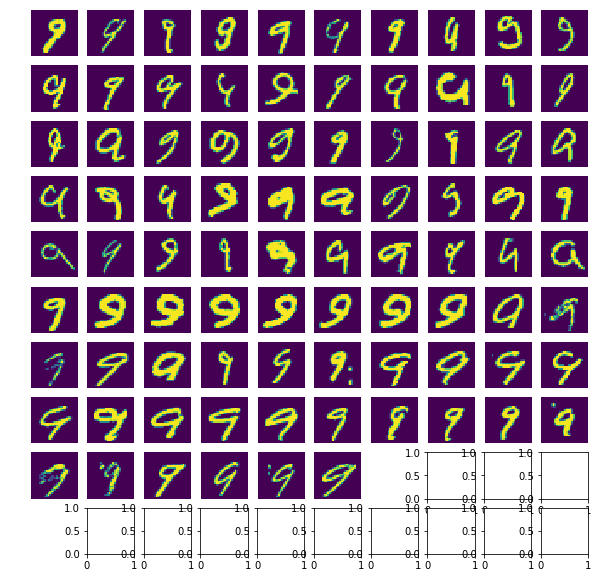

In [15]:
num = 9
specific_label = np_utils.to_categorical(np.full((len(test_img[num])), num), 10)
specific_test_accuracy, test_predict, test_logit = get_accuracy(sess, logits, np.expand_dims(test_img[num], axis=-1), specific_label)
print(specific_test_accuracy)

logit = np.argmax(test_logit, 1)
indx = np.where(test_predict[:] == 0.)[0]
print("{} / {}".format(len(indx), len(test_img[num])))
nrow = np.ceil(np.sqrt(len(indx))).astype(np.int)
fig, ax = plt.subplots(nrows=nrow, ncols=nrow, figsize = (10, 10))
img = test_img[num][indx]
for i in range(nrow):
    for j in range(nrow):
        if nrow*i+j >= len(indx):
            ax[i][j].axis('off')
            break
        else:
            ax[i][j].imshow(img[nrow*i+j])
            ax[i][j].axis('off')

logit = logit[indx]

print("wrong prediction")
for i in range(nrow):
    if nrow*(i+1) < len(indx):
        print(logit[nrow*i : nrow*(i+1)])
    else:
        print(logit[nrow*i : len(indx)])

for pred in logit:
    logit_class[pred] += 1
for num in range(10):
    if not logit_class[num] == 0:
        print('The number of prediction as {} : {}'.format(num, logit_class[num]))

plt.show()